# Active Learning Pipeline

In [1]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf
import sys

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import pickle
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import pytorch_lightning as pl
from tqdm.auto import tqdm

from scripts.utils import ScaleData, train_keys, target_keys

/unix/atlastracking/jbarr/ukaea-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preparing Data

For now we will only look at a pipeline for the ITG flux. Starting with data that does give a QuaLiKiz result, run the ITG classifier and for data that is unstable use the QLKNN regressor to predict the flux.

In [2]:
train_data = pd.read_pickle("/unix/atlastracking/jbarr/train_data_clipped.pkl").sample(1_000_000)
validation_data = pd.read_pickle("/unix/atlastracking/jbarr/valid_data_clipped.pkl")

# Keep only the data that gives an output
train_data = train_data[train_data["target"] == 1]
validation_data = validation_data[validation_data["target"] == 1]


0.2672560004111631


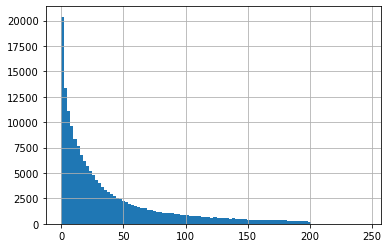

In [3]:
train_data[train_data["efiitg_gb"] != 0]["efiitg_gb"].hist(bins=100)
print(len(train_data[train_data["efiitg_gb"] != 0]) / len(train_data))

### Basic ITG Models for Prototyping

In [4]:
torch.set_default_dtype(torch.float32)

class ITG_Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(15, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        X = self.model(x)
        return X

class ITG_Regressor(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(15, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 1),

        )

    def forward(self, x):
        X = self.model(x.float())
        return X

class ITGDataset(Dataset):
    def __init__(self, X, y, z = None):
        self.X = X
        self.y = y
        self.z = z

    # number of rows in the dataset
    def __len__(self):
        return len(self.y)

    # get a row at an index
    def __getitem__(self, idx):
        if self.z is not None:
            return[self.X[idx], self.y[idx], self.z[idx]]
        else:
            return [self.X[idx], self.y[idx]]

#### Pretrain Classifier
We will pretrain the classifier and then freeze the weights so that we only update the regressor during the active learning process.

In [5]:
keep_keys = train_keys + ["efiitg_gb"]

train_data = train_data[keep_keys]
validation_data = validation_data[keep_keys]

nt, nv = train_data.shape[0], validation_data.shape[0]
nt_nan, nv_nan =  train_data['efiitg_gb'].isna().sum(), validation_data['efiitg_gb'].isna().sum()

train_data = train_data.dropna()
validation_data = validation_data.dropna()

assert train_data.shape[0] + nt_nan == nt
assert validation_data.shape[0] + nv_nan == nv

train_data['itg'] = np.where(train_data['efiitg_gb'] != 0, 1, 0)
validation_data['itg'] = np.where(validation_data['efiitg_gb'] != 0, 1, 0)

assert len(train_data['itg'].unique()) == 2
assert len(validation_data['itg'].unique()) == 2

In [6]:
#x_train, y_train = train_data.iloc[:,:-1].to_numpy(), train_data.iloc[:,-1].to_numpy()
#x_val, y_val = validation_data.iloc[:,:-1].to_numpy(), validation_data.iloc[:,-1].to_numpy()
x_train = train_data[train_keys].to_numpy()
y_train_class = train_data['itg'].to_numpy()
y_train_reg =  train_data['efiitg_gb'].to_numpy()

x_val = validation_data[train_keys].to_numpy()
y_val_class = validation_data['itg'].to_numpy()
y_val_reg =  validation_data['efiitg_gb'].to_numpy()

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform (x_val)

scaler_reg = StandardScaler()
scaler_reg.fit(y_train_reg.reshape(-1,1))
y_train_reg = scaler_reg.transform(y_train_reg.reshape(-1,1))
y_val_reg = scaler_reg.transform(y_val_reg.reshape(-1,1))

training = ITGDataset(x_train, y_train_class)
train_dataloader = DataLoader(training, batch_size=1024, shuffle=True)

validation = ITGDataset(x_val, y_val_class)
validation_dataloader = DataLoader(validation, batch_size=1024, shuffle=True)


In [7]:
classifier = ITG_Classifier()

learning_rate = 1e-3
batch_size = 2048
epochs = 10

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate, weight_decay=1e-4)

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred, y.unsqueeze(-1).float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch == num_batches - 1:
            loss = loss.item()
            print(f"loss: {loss:>7f}")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, y.unsqueeze(-1).float()).item()
            # calculate test accuracy
            pred_class = torch.round(pred.squeeze())
            correct += torch.sum(pred_class == y.float()).item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, classifier, loss_fn, optimizer)
    test_loop(validation_dataloader, classifier, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.146998
Test Error: 
 Accuracy: 93.9%, Avg loss: 0.144894 

Epoch 2
-------------------------------
loss: 0.119972
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.124943 

Epoch 3
-------------------------------
loss: 0.104817
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.118619 

Epoch 4
-------------------------------
loss: 0.115866
Test Error: 
 Accuracy: 95.2%, Avg loss: 0.114380 

Epoch 5
-------------------------------
loss: 0.132803
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.110666 

Epoch 6
-------------------------------
loss: 0.022314
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.108232 

Epoch 7
-------------------------------
loss: 0.156079
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.108961 

Epoch 8
-------------------------------
loss: 0.154978
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.107895 

Epoch 9
-------------------------------
loss: 0.061063
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.105405 

Epoch 10
----------------------------

In [10]:
# temporarily save model
torch.save(classifier.state_dict(), "classifier_model.pt")

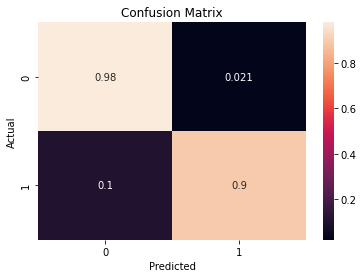

In [11]:
# get confusion matrix
y_pred = classifier(torch.tensor(x_val).float())
y_pred = torch.round(y_pred.squeeze())
y_pred = y_pred.detach().numpy()

con_mat = confusion_matrix(y_val_class, y_pred)
con_mat = con_mat / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(con_mat, annot=True).set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual');

### Pretrain Regressor

Now we will pretrain the regressor on a very small subset of the data and use that as our base for the active learning process.

In [12]:
indices = np.random.choice(len(x_train), size=10_000, replace=False)

reg_train = ITGDataset(x_train[indices], y_train_class[indices], y_train_reg[indices])
reg_train_dataloader = DataLoader(reg_train, batch_size=1000, shuffle=True)

reg_val = ITGDataset(x_val, y_val_class, y_val_reg)
reg_val_dataloader = DataLoader(reg_val, batch_size=1024, shuffle=False)

In [13]:
def regression_train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    for batch, (X, y, z) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred, z.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch == num_batches - 1:
            loss = loss.item()
            print(f"loss: {loss:>7f}")

def regression_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y, z in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, z.float()).item()

    test_loss /= num_batches
    print(f"Test Error - avg loss: {test_loss:>8f} \n")

In [14]:
regressor = ITG_Regressor()

learning_rate = 1e-3
batch_size = 2048
epochs = 10

MSE_loss = nn.MSELoss()
optimizer = torch.optim.Adam(regressor.parameters(), lr=learning_rate, weight_decay=1e-4)

In [15]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    regression_train_loop(reg_train_dataloader, regressor, MSE_loss, optimizer)
    regression_test_loop(reg_val_dataloader, regressor, MSE_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.854099
Test Error - avg loss: 0.795979 

Epoch 2
-------------------------------
loss: 0.629711
Test Error - avg loss: 0.693082 

Epoch 3
-------------------------------
loss: 0.568184
Test Error - avg loss: 0.613299 

Epoch 4
-------------------------------
loss: 0.638020
Test Error - avg loss: 0.525746 

Epoch 5
-------------------------------
loss: 0.536548
Test Error - avg loss: 0.459528 

Epoch 6
-------------------------------
loss: 0.308821
Test Error - avg loss: 0.381521 

Epoch 7
-------------------------------
loss: 0.391484
Test Error - avg loss: 0.336157 

Epoch 8
-------------------------------
loss: 0.267312
Test Error - avg loss: 0.314637 

Epoch 9
-------------------------------
loss: 0.411627
Test Error - avg loss: 0.300240 

Epoch 10
-------------------------------
loss: 0.325678
Test Error - avg loss: 0.289907 

Done!


In [16]:
# temporarily save model
torch.save(regressor.state_dict(), "regression_model.pt")

In [17]:
# load regression model
regressor = ITG_Regressor()
regressor.load_state_dict(torch.load("regression_model.pt"))

<All keys matched successfully>

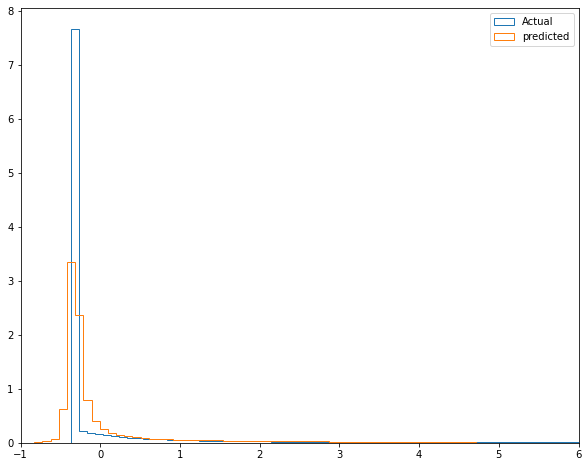

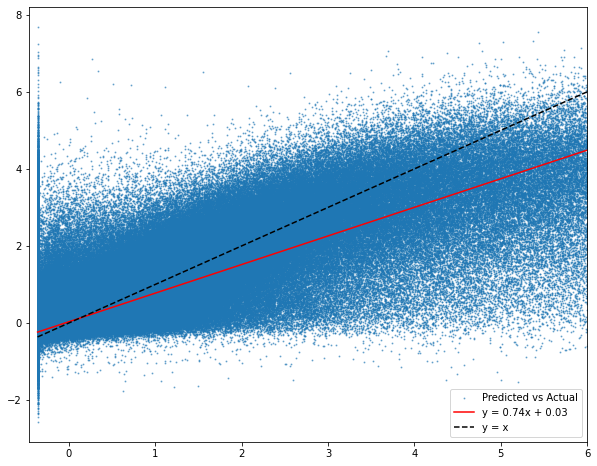

In [18]:
# plot histogram of predicted values
y_pred = regressor(torch.tensor(x_val).float()).detach().numpy()

plt.figure(figsize=(10,8))
plt.hist(y_val_reg, bins=100, density = True, histtype = 'step', label="Actual");
plt.hist(y_pred, bins=100, density=True, histtype='step', label='predicted');
plt.legend();
plt.xlim(-1,6)

# plot scatter plot of predicted vs actual
plt.figure(figsize = (10,8))
plt.scatter(y_val_reg, y_pred, s=1, alpha=0.5, label = "Predicted vs Actual");

min_x = np.min(y_val_reg)

# get line of best fit
m, b = np.polyfit(y_val_reg.squeeze(), y_pred, 1)
plt.plot(np.linspace(min_x,6,100), m*np.linspace(min_x,6,100)+b, 'r-', label=f'y = {m[0]:.2f}x + {b[0]:.2f}');

plt.plot([min_x,6],[min_x,6], 'k--', label = 'y = x');
plt.xlim(min_x - 0.1,6)
plt.legend();



#### Active Learning

First pass, will put everything into nice functions after

In [19]:
# Start with only a small subset of the data
indices = np.random.choice(len(x_train), size=10_000, replace=False)

training_reg = ITGDataset(x_train[indices], y_train_class[indices], y_train_reg[indices])
train_dataloader_reg = DataLoader(training_reg, batch_size=10_000, shuffle=True)

In [20]:
classifier.eval()

for X, y, z in train_dataloader_reg:
    pred = classifier(X.float())
    pred_class = torch.round(pred.squeeze()).detach().numpy()
    pred_class = pred_class.astype(int)
    # add data that returns one to a new dataset
    training_reg_pass = ITGDataset(X[pred_class == 1], y[pred_class == 1], z[pred_class == 1])

print(f"Number of points passing classifier: {len(training_reg_pass)}")
training_reg_pass_dataloader = DataLoader(training_reg_pass, shuffle=True)

Number of points passing classifier: 2596


In [21]:
def enable_dropout(model):
    """Function to enable the dropout layers during test-time"""
    for m in model.modules():
        if m.__class__.__name__.startswith("Dropout"):
            m.train()

100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


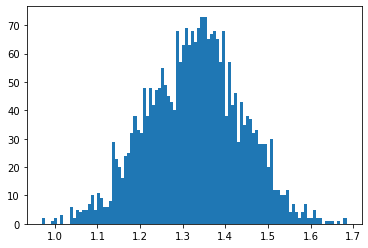

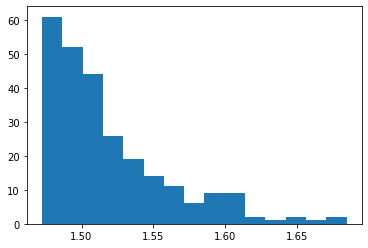

In [22]:
regressor.eval()
enable_dropout(regressor)

# evaluate model on training data 100 times and return points with largest uncertainty
runs = []
for i in tqdm(range(100)):
    step_list = []
    for step, (x, y, z) in enumerate(training_reg_pass_dataloader):

        predictions = regressor(x.float()).detach().numpy()
        step_list.append(predictions)

    flattened_predictions = np.array(step_list).flatten()
    runs.append(flattened_predictions)

out_std = np.std(np.array(runs), axis=0)

plt.figure()
plt.hist(out_std, bins=100)

# get indices of top 10% of points
top_indices = np.argsort(out_std)[-int(len(out_std) * 0.1):]
plt.figure()
plt.hist(out_std[top_indices], bins=15)

reg_dataset = ITGDataset(x_train[top_indices], y_train_class[top_indices], y_train_reg[top_indices])
reg_dataloader = DataLoader(reg_dataset, shuffle=True)



### Maybe train using some of the original training dataset and high variance points for balance? 

In [23]:
regressor.train()
optimizer = torch.optim.Adam(regressor.parameters(), lr= 0.1 *learning_rate, weight_decay=1e-4)

print(f"Validation MSE loss before fine tuning using high variance points:")
regression_test_loop(reg_val_dataloader, regressor, MSE_loss)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    regression_train_loop(reg_dataloader, regressor, MSE_loss, optimizer)
    regression_test_loop(reg_val_dataloader, regressor, MSE_loss)
print("Done!")

Validation MSE loss before fine tuning using high variance points:
Test Error - avg loss: 0.290954 

Epoch 1
-------------------------------
loss: 0.008330
Test Error - avg loss: 0.290392 

Epoch 2
-------------------------------
loss: 0.003058
Test Error - avg loss: 0.335885 

Epoch 3
-------------------------------
loss: 0.001204
Test Error - avg loss: 0.303845 

Epoch 4
-------------------------------
loss: 0.000071
Test Error - avg loss: 0.311973 

Epoch 5
-------------------------------
loss: 0.004332
Test Error - avg loss: 0.406151 

Epoch 6
-------------------------------
loss: 0.000061
Test Error - avg loss: 0.349363 

Epoch 7
-------------------------------
loss: 0.001584
Test Error - avg loss: 0.314289 

Epoch 8
-------------------------------
loss: 0.001094
Test Error - avg loss: 0.311690 

Epoch 9
-------------------------------
loss: 0.007323
Test Error - avg loss: 0.325972 

Epoch 10
-------------------------------
loss: 0.000067
Test Error - avg loss: 0.317793 

Done!


In [24]:
# torch.utils.data.ConcatDataset(datasets)